In this notebook, we walk through an example analysis of a conjugate Inverse-Gamma distribution to demonstrate why we care about tracking variational parameters in the constrained space.

In [45]:
import matplotlib.pyplot as plt 
import numpy as np
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import SVI, TraceMeanField_ELBO
from numpyro.infer.autoguide import AutoNormal
from numpyro.optim import Adam

from bakeoff.posteriors import invgamma_posterior

We will use the following model. We draw 10 observations $y_1, y_2, \ldots, y_n$ from a $\mathcal{N}(\mu^*, \sigma^2)$ distribution. Say we know the value of $\mu^*$ is $0$ and we have an Inverse Conjugate prior over $\sigma^2$.
\begin{align*}
y_1, y_2, \ldots, y_n \:\textrm{i.i.d.}\:&\sim \mathcal{N}(\mu^*=0, \sigma^2)\\
\sigma^2 &\sim \textrm{InverseGamma}(\alpha_{\textrm{prior}}=5, \beta_{\textrm{prior}}=7)
\end{align*}

In [39]:
# config data
alpha_prior = 5.
beta_prior = 7.
n = 10
sigma2_like = 3.
mu_like = 0.
adam_step = 0.05
max_iters = 10_000

# simulate data
y = np.random.normal(loc=mu_like, scale=np.sqrt(sigma2_like), size=n)
y = jnp.array(y)
true_posts = invgamma_posterior(y, mu_like, alpha_prior, beta_prior)

def model(y):
    sigma2 = numpyro.sample("sigma2", dist.InverseGamma(alpha_prior, beta_prior))
    numpyro.sample("y", dist.Normal(mu_like, jnp.sqrt(sigma2)), obs=y)
optimizer = Adam(adam_step)
elbo = TraceMeanField_ELBO(num_particles=100)
guide = AutoNormal(model)
svi = SVI(model, guide, optimizer, loss=elbo)

@jax.jit
def run_svi_loop(rng_key, y_data):
    svi_state = svi.init(rng_key, y_data)
    def body_fn(i, val):
        svi_state, tracker = val
        svi_state, loss = svi.update(svi_state, y_data)
        params = svi.get_params(svi_state)
        tracker = {
            'mu_loc': tracker['mu_loc'].at[i].set(params['sigma2_auto_loc']),
            'std_loc': tracker['std_loc'].at[i].set(params['sigma2_auto_scale']),
        }
        return svi_state, tracker
    tracker = {
            'mu_loc': jnp.zeros(max_iters),
            'std_loc': jnp.zeros(max_iters)
        }
    final_state, final_tracker = jax.lax.fori_loop(0, max_iters, body_fn, (svi_state, tracker))
    svi_elbo = -svi.evaluate(final_state, y_data)
    return svi_elbo, final_tracker

    # run SVI inference with parameter tracking
rng_keys = jax.random.PRNGKey(0)
elbos, trackers = run_svi_loop(rng_keys, y)

In [46]:
# compute the transformation applied to the variational parameters
def transform(mu, std):
    # sample from mu, std and apply transformation to samples and then return mean and std of transformed samples
    samples = jax.random.normal(jax.random.PRNGKey(1), (5000,)) * std + mu
    transformed_samples = jnp.exp(samples)
    return jnp.mean(transformed_samples), jnp.std(transformed_samples)

transformed_tracker = {
    'mu': jnp.zeros(max_iters),
    'std': jnp.zeros(max_iters)
}
for i in range(max_iters):
    mu, std = transform(trackers['mu_loc'][i], trackers['std_loc'][i])
    transformed_tracker['mu'] = transformed_tracker['mu'].at[i].set(mu)
    transformed_tracker['std'] = transformed_tracker['std'].at[i].set(std)

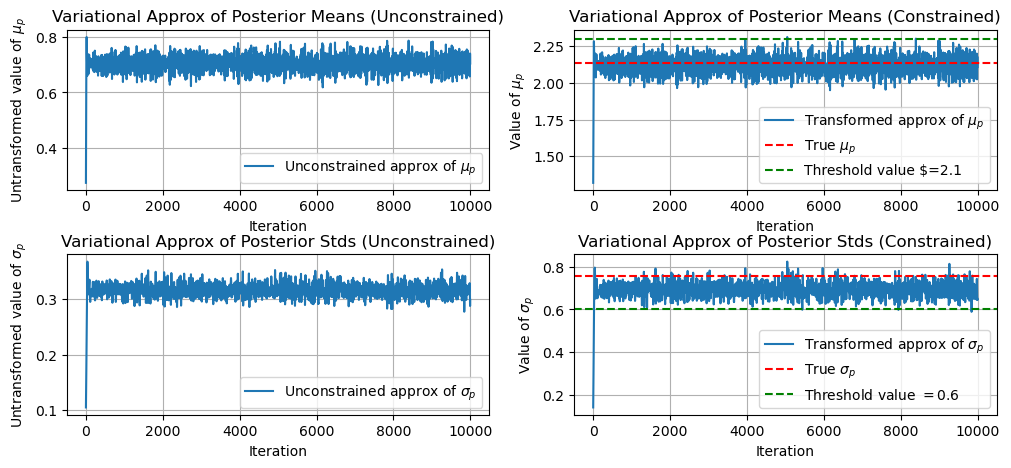

In [50]:
# plot side-by-side the variational parameters in the unconstrained space and the constrained space
fig, axs = plt.subplots(2, 2, figsize=(12, 5))
# left is mean over std plot in unconstrained space, right is mean over std plot in constrained space
plt.subplots_adjust(hspace=0.4)
axs[0, 0].plot(trackers['mu_loc'], label=r'Unconstrained approx of $\mu_p$')
axs[1, 0].plot(trackers['std_loc'], label=r'Unconstrained approx of $\sigma_p$')
axs[0, 0].set_title('Variational Approx of Posterior Means (Unconstrained)')
axs[0, 0].set_xlabel('Iteration')
axs[0, 0].set_ylabel(r'Untransformed value of $\mu_p$')
axs[0, 0].legend()
axs[1, 0].set_title('Variational Approx of Posterior Stds (Unconstrained)')
axs[1, 0].set_xlabel('Iteration')
axs[1, 0].set_ylabel(r'Untransformed value of $\sigma_p$')
axs[1, 0].legend()
axs[0, 0].grid()
axs[1, 0].grid()

axs[0, 1].plot(transformed_tracker['mu'], label=r'Transformed approx of $\mu_p$')
axs[1, 1].plot(transformed_tracker['std'], label=r'Transformed approx of $\sigma_p$')
axs[0, 1].axhline(true_posts['mean_post'], color='r', linestyle='--', label=r'True $\mu_p$')
axs[1, 1].axhline(true_posts['std_post'], color='r', linestyle='--', label=r'True $\sigma_p$')
axs[0, 1].axhline(2.3, color='g', linestyle='--', label=r'Threshold value $=2.1')
axs[1, 1].axhline(0.6, color='g', linestyle='--', label=r'Threshold value $=0.6$')
axs[0, 1].set_title('Variational Approx of Posterior Means (Constrained)')
axs[0, 1].set_xlabel('Iteration')
axs[0, 1].set_ylabel(r'Value of $\mu_p$')
axs[0, 1].legend()
axs[1, 1].set_title('Variational Approx of Posterior Stds (Constrained)')
axs[1, 1].set_xlabel('Iteration')
axs[1, 1].set_ylabel(r'Value of $\sigma_p$')
axs[1, 1].legend()
axs[0, 1].grid()
axs[1, 1].grid()

In [10]:
true_posts

{'alpha_post': 10.0,
 'beta_post': Array(23.678635, dtype=float32),
 'mean_post': Array(2.6309595, dtype=float32),
 'std_post': np.float32(0.9301846)}

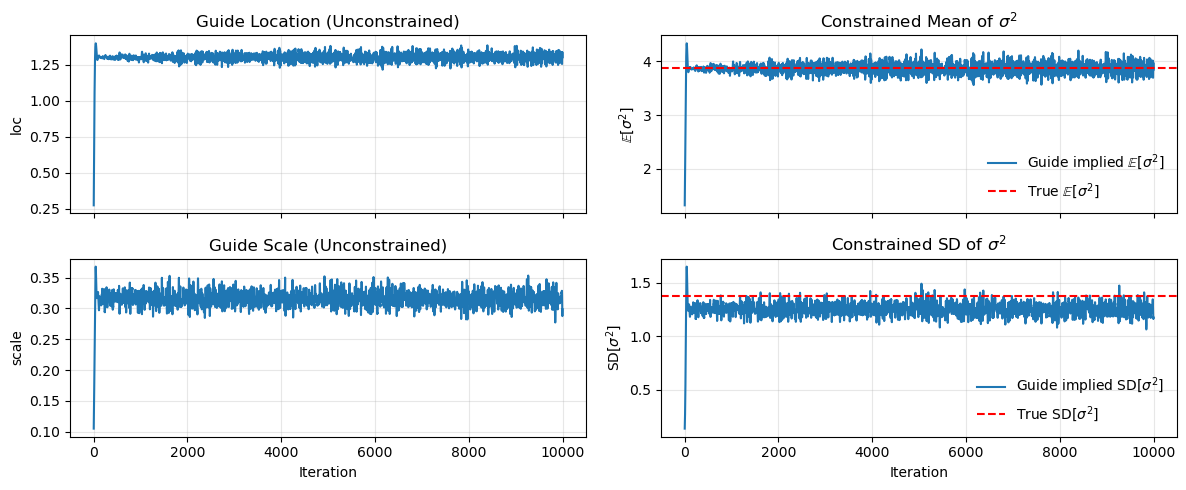

In [44]:
# --- Full, runnable NumPyro example: unconstrained vs constrained tracking for σ² ---

import numpy as np
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import SVI, TraceMeanField_ELBO
from numpyro.infer.autoguide import AutoNormal
from numpyro.optim import Adam
import matplotlib.pyplot as plt

# -----------------------------
# Config / data generation
# -----------------------------
alpha_prior = 5.0      # IG shape
beta_prior  = 7.0      # IG scale
n           = 10
sigma2_like = 3.0      # true σ² used to generate data
mu_like     = 0.0      # known mean
adam_step   = 0.05
max_iters   = 10_000
rng_key     = jax.random.PRNGKey(0)

# simulate data
y = np.random.normal(loc=mu_like, scale=np.sqrt(sigma2_like), size=n)
y = jnp.array(y)

# -----------------------------
# Model: σ² ~ InverseGamma, y_i ~ N(μ, σ²) with known μ
# -----------------------------
def model(y_data):
    sigma2 = numpyro.sample("sigma2", dist.InverseGamma(alpha_prior, beta_prior))
    numpyro.sample("y", dist.Normal(mu_like, jnp.sqrt(sigma2)), obs=y_data)

# Guide + optimizer + ELBO
optimizer = Adam(adam_step)
elbo      = TraceMeanField_ELBO(num_particles=100)
guide     = AutoNormal(model)
svi       = SVI(model, guide, optimizer, loss=elbo)

# -----------------------------
# SVI loop with tracking of guide params (unconstrained)
# AutoNormal creates params named like "sigma2_auto_loc" and "sigma2_auto_scale"
# -----------------------------
@jax.jit
def run_svi_loop(rng_key, y_data):
    svi_state = svi.init(rng_key, y_data)

    def body_fn(i, val):
        svi_state, tracker = val
        svi_state, loss = svi.update(svi_state, y_data)
        params = svi.get_params(svi_state)
        # Unconstrained guide parameters (Normal on log-scale for σ²)
        tracker = {
            'mu_loc':  tracker['mu_loc'].at[i].set(params['sigma2_auto_loc']),
            'std_loc': tracker['std_loc'].at[i].set(params['sigma2_auto_scale']),
        }
        return svi_state, tracker

    tracker = {
        'mu_loc':  jnp.zeros(max_iters),
        'std_loc': jnp.zeros(max_iters),
    }
    final_state, final_tracker = jax.lax.fori_loop(0, max_iters, body_fn, (svi_state, tracker))
    final_elbo = -svi.evaluate(final_state, y_data)
    return final_elbo, final_tracker

final_elbo, traces = run_svi_loop(rng_key, y)

# -----------------------------
# True IG posterior moments for σ² (for comparison on the constrained scale)
# prior: IG(α0, β0), likelihood y_i ~ N(μ, σ²)
# α_n = α0 + n/2, β_n = β0 + 0.5 * sum (y_i - μ)^2
# E[σ²] = β_n / (α_n - 1),  SD[σ²] = β_n / ((α_n - 1) * sqrt(α_n - 2))
# (requires α_n > 2, which holds here)
# -----------------------------
alpha_post = alpha_prior + n / 2.0
beta_post  = beta_prior  + 0.5 * jnp.sum((y - mu_like) ** 2)
true_mean_sigma2 = beta_post / (alpha_post - 1.0)
true_std_sigma2  = beta_post / ((alpha_post - 1.0) * jnp.sqrt(alpha_post - 2.0))

# -----------------------------
# Constrained (σ²) moments implied by the lognormal transform of the guide
# If u ~ N(mu_loc, std_loc^2) and σ² = exp(u), then:
#   E[σ²] = exp(mu_loc + 0.5 * std_loc^2)
#   Var[σ²] = (exp(std_loc^2) - 1) * exp(2*mu_loc + std_loc^2)
# -----------------------------
it      = np.arange(len(traces['mu_loc']))
mu_loc  = np.array(traces['mu_loc'])     # unconstrained location
std_loc = np.array(traces['std_loc'])    # unconstrained scale

constrained_mean = np.exp(mu_loc + 0.5 * std_loc**2)
constrained_var  = (np.exp(std_loc**2) - 1.0) * np.exp(2.0 * mu_loc + std_loc**2)
constrained_std  = np.sqrt(constrained_var)

# -----------------------------
# Plots: left = unconstrained guide params; right = constrained σ² moments
# -----------------------------
fig, axs = plt.subplots(2, 2, figsize=(12, 5), sharex='col')

# Left column: unconstrained guide parameters
axs[0,0].plot(it, mu_loc)
axs[0,0].set_title("Guide Location (Unconstrained)")
axs[0,0].set_ylabel(r"loc")

axs[1,0].plot(it, std_loc)
axs[1,0].set_title("Guide Scale (Unconstrained)")
axs[1,0].set_xlabel("Iteration")
axs[1,0].set_ylabel(r"scale")

# Right column: constrained σ² moments
axs[0,1].plot(it, constrained_mean, label=r"Guide implied $\mathbb{E}[\sigma^2]$")
axs[0,1].axhline(float(true_mean_sigma2), ls="--", color="r", label=r"True $\mathbb{E}[\sigma^2]$")
axs[0,1].set_title(r"Constrained Mean of $\sigma^2$")
axs[0,1].set_ylabel(r"$\mathbb{E}[\sigma^2]$")
axs[0,1].legend(loc="best", frameon=False)

axs[1,1].plot(it, constrained_std, label=r"Guide implied $\mathrm{SD}[\sigma^2]$")
axs[1,1].axhline(float(true_std_sigma2), ls="--", color="r", label=r"True $\mathrm{SD}[\sigma^2]$")
axs[1,1].set_title(r"Constrained SD of $\sigma^2$")
axs[1,1].set_xlabel("Iteration")
axs[1,1].set_ylabel(r"$\mathrm{SD}[\sigma^2]$")
axs[1,1].legend(loc="best", frameon=False)

for ax in axs.ravel():
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()



In [ ]:

plt.tight_layout()
plt.show()
